Random Forests, a leading competitor to XGBoost, are ensembles of decision trees. 
- The difference is that random forests combine trees via bagging, while XGBoost combines trees via boosting.
	
Random Forests are important because they provide valuable insights into the structure of tree-based ensembles. A random forest may consist of hundreds or thosands of decision trees whose predictions are combined for the final result.

## Random Forest Classifiers

Let's use a random forest classifier to predict whether a user makes more or less than 50,000$ using the census income dataset we cleaned and scored before.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_census = pd.read_csv("data/census_cleaned.csv")
df_census.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
X_census = df_census.iloc[:, :-1]
y_census = df_census.iloc[:, -1]

# n_estimators=10, a previous scikit-learn default sufficient to speed up computations
rf_cls = RandomForestClassifier(n_estimators=10, random_state=2, n_jobs=-1)

# cross_val_score splits, fits, and scores the data
scores = cross_val_score(rf_cls, X_census, y_census, cv=5)

print(f"Accuracy: {np.round(scores, 3)}")
print(f"Accuracy mean: {np.round(scores.mean(), 3)}")

Accuracy: [0.851 0.844 0.851 0.852 0.851]
Accuracy mean: 0.85


The default random forest classifier provides a better score for the census income dataset than the decision tree in the previous chapter (81%), but not quite good as XGBoost in Chapter 1 (86%).

- Improved performance is likely due to the bagging method. With 10 trees in this forest, each prediction is based on 10 decision trees instead of 1. The trees are bootstrapped, which increases diversity, and aggregated, which reduces variance.


By default, random forest classifier select from the **square root of the total number of features** when looking for a split. So if there are 100 features, each decision tree will only consider 10 features when choosing a split. Thus two trees with duplicate samples may give very different predictions due to different splits. This is another way that random forests reduce variance. 

## Random Forest Regressors

In a random forest regressor, the samples are bootstrapped, as with the random forest classifier, but the max number of features is the total number of features instead of square root.

Furthermore, the final prediction is made by taking the average of the predictions of all the trees, instead of a majority rules vote.

In [11]:
df_bikes = pd.read_csv("data/bike_rentals_cleaned.csv")

X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]

In [12]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=10, random_state=2, n_jobs=-1)

scores = cross_val_score(rf_reg, X_bikes, y_bikes, scoring="neg_mean_squared_error", cv=10)

print(f"Scores: {scores}")
rmse = np.sqrt(-scores)

print(f"RMSE: ", np.round(rmse, 3))
print(f"RMSE mean: ", np.round(rmse.mean(), 3))

Scores: [ -642379.50405405  -336385.43917808  -303983.22164384  -716896.97890411
  -801114.29821918 -1204553.53780822  -798768.03575342  -654941.32013699
  -694701.78232877 -4601222.85260274]
RMSE:  [ 801.486  579.987  551.347  846.698  895.05  1097.522  893.738  809.284
  833.488 2145.046]
RMSE mean:  945.365


The random forest performs respectably (min-max NormalizedRMSE 0.108), though not as well as other models that we have seen. Linear Regression (min-max NormalizedRMSE 0.103), and XGBoost Regressor (min-max NormalizedRMSE 0.080)

## Random Forest Hyperparameters

The range of random forest hyperparameters is large. (Inheriting all the ones from decision trees also.) 

#### `oob_score`

Random Forests select decision trees via bagging, meaning that samples are selected with replacement. After all of the samples have been chosen, some samples should remain as **not chosen**. It is possible to hold back these samples as the **test set**.
- After the model is fit on one tree, the model can immediately be scored against this test set if `oob_score=True`. 

In [13]:
# No need to split train - test set since we are using oob_score
rf_cls_oob = RandomForestClassifier(oob_score=True, n_estimators=10, random_state=2, n_jobs=-1)
rf_cls_oob.fit(X_census, y_census)

rf_cls_oob.oob_score_

0.8343109855348423

As described previously, `oob_score` is created by scoring samples on individual trees excluded during the training phase. When the number of trees in the forest is small, as is the case with 10 estimators, there may not be enough test samples to maximize accuracy. 
- More trees mean more samples, and often greater accuracy.

#### `n_estimators`

Random Forests are powerful when there are many trees in the forest. Then the question is, *how many is enough?*
- While 100 trees may be enough to cut down on variance and obtain good scores, for larger datasets, 500 or more trees may be required.

#### `warm_start`

This hyperparameter is great for determining the number of trees in the forest (*n_estimators*). When `warm_start=True`, adding more trees does not require starting over from scratch, but rather starts where the preivous model stopped. 

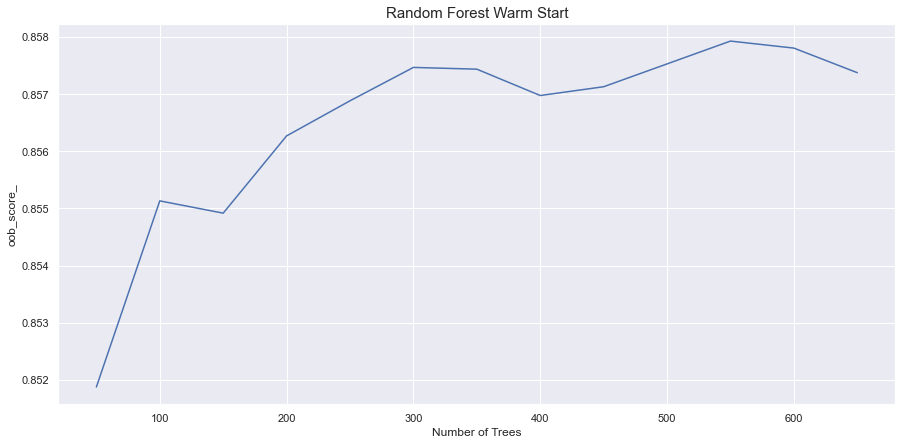

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn to dark grid
sns.set()

# Initialize empty list of oob_scores
oob_scores = []

# Initialize Random Forest classifier as rf_cls with 50 estimators
rf_cls = RandomForestClassifier(n_estimators=50, warm_start=True, oob_score=True,
            random_state=2 ,n_jobs=-1)

# Fit classifier to census income dataset
rf_cls.fit(X_census, y_census)

# Append oob_score to the list
oob_scores.append(rf_cls.oob_score_)

est = 50
estimators = [est]

for i in range(12):

    # Add 50 to estimators, and append to estimators list
    est += 50
    estimators.append(est)

    # Set the new estimator count on the classifier
    rf_cls.set_params(n_estimators=est)

    # Fit classifier on dataset
    rf_cls.fit(X_census, y_census)

    # Append oob scores to the oob_scores list
    oob_scores.append(rf_cls.oob_score_)

# Plot number of estimators vs oob_scores
plt.figure(figsize=(15, 7))
plt.plot(estimators, oob_scores)
plt.xlabel("Number of Trees")
plt.ylabel("oob_score_")
plt.title("Random Forest Warm Start", fontsize=15)
plt.savefig("random_forest_warm_start", dpi=325)
plt.show()

As you can see, the number of trees tend to peak at around 300, and then it is more costly and time-consuming to use more than 300 trees, and the gains are minimal at best.

## Random Forest - A Case Study

Goal is to predict the number of bike rentals per day depending upon the several features, using bike rentals dataset. Earlier in the chapter we manage to obtain an RMSE of 945 bikes with a random forest regressor with cross-validation.

In [16]:
df_bikes = pd.read_csv("data/bike_rentals_cleaned.csv")
df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [37]:
from utility import rand_search_reg
from sklearn.model_selection import train_test_split

X_bikes = df_bikes.iloc[:, :-1]
y_bikes = df_bikes.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

rand_search_reg(X_train, y_train, X_test, y_test,
    params={'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
            'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
            'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
            'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]
            })

Best Params: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
Training score: 759.076
Test set score: 701.802126075713


This is a major improvement. Let's see if we can do better by narrowing the range.

In [38]:
rand_search_reg(X_train, y_train, X_test, y_test,
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]
            })

Best Params: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 10}
Training score: 679.052
Test set score: 626.5408983236347


The score has improved yet again. Now let's increase the number of runs, and give more options for max_depth.

In [40]:
rand_search_reg(X_train, y_train, X_test, y_test,
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,4,6,8,10,12, 15, 20]
            }, runs = 20)

Best Params: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
Training score: 675.128
Test set score: 619.0138286133003


The score keeps getting better. At this point, it may be worth narrowing the ranges further, based upon the previous results

In [41]:
rand_search_reg(X_train, y_train, X_test, y_test,
    params={'min_samples_leaf':[1,2,3,4,5,6],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12],
            'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,8,10,12,14,16,18,20]
            }, runs = 20)

Best Params: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.08, 'max_features': 0.5, 'max_depth': 12}
Training score: 673.657
Test set score: 616.1890813502575


Lets try with increasing the number of estimators.

In [43]:
rand_search_reg(X_train, y_train, X_test, y_test,
    params={'min_samples_leaf':[1,2,3,4,5,6],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.08, 0.10, 0.12],
            'max_features':['auto', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,8,10,12,14,16,18,20],
            'n_estimators': [150]
            }, runs = 20)

Best Params: {'n_estimators': 150, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.08, 'max_features': 0.5, 'max_depth': 12}
Training score: 673.903
Test set score: 611.4875605212735


Finallyi let's place our best model in **cross_val_score** to see how the result compares with the original.

In [44]:
rf = RandomForestRegressor(n_estimators=150,
    min_impurity_decrease=0.08, max_features=0.5, max_depth=12,
    warm_start=True, n_jobs=-1, random_state=2)

scores = cross_val_score(rf, X_bikes, y_bikes, 
    scoring="neg_mean_squared_error", cv=10)

rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE Mean: {np.round(rmse.mean(), 3)}")

RMSE: [ 857.22   502.685  542.613  813.863  772.447  733.553  870.296  802.451
  739.206 1545.175]
RMSE Mean: 817.951


The RMSE goes back up to **817**. The score is much better than **945**, but its considerably worse than **611**. What's going on here?

- There may be an issue with the last split in `cross_val_score` since its score is twice as bad as the others. Lets see if shuffling the data does the trick?

In [45]:
from sklearn.utils import shuffle

df_shuffle_bikes = shuffle(df_bikes, random_state=2)
X_shuffle_bikes = df_shuffle_bikes.iloc[:,:-1]
y_shuffle_bikes = df_shuffle_bikes.iloc[:,-1]

rf = RandomForestRegressor(n_estimators=150,
    min_impurity_decrease=0.08, max_features=0.5, max_depth=12,
    warm_start=True, n_jobs=-1, random_state=2)

scores = cross_val_score(rf, X_shuffle_bikes, y_shuffle_bikes, 
    scoring="neg_mean_squared_error", cv=10)

rmse = np.sqrt(-scores)
print(f"RMSE: {np.round(rmse, 3)}")
print(f"RMSE Mean: {np.round(rmse.mean(), 3)}")

RMSE: [613.972 685.997 460.284 549.958 611.606 709.871 769.693 662.781 743.442
 613.821]
RMSE Mean: 642.142


In the shuffled data, there is no issue with the last split, and the score is much higher, as expected.